# Homework 4 Part 3 - Generative Model Simple Decoding - Translation - Visualization

## Course Name: Large Language Models
#### Lecturers: Dr. Soleimani, Dr. Rohban, Dr. Asgari

---

#### Notebooks Supervised By: MohammadAli SadraeiJavaheri
#### Notebooks Prepared By: Ali Razghandi, Mahdi Zakizadeh, Faridoun Mehri

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


In this assignment, we delve into the workings of generative language models, focusing on the decoding process, the intricacies of translation tasks, and the visualization of attention mechanisms. Through hands-on exercises, you'll gain insights into the capabilities and inner workings of state-of-the-art NLP models.

- The items you need to answer are highlighted in <font color="green">**bold green**</font>, and the coding parts you need to implement are denoted by:

```
## Your code begins ##
...
## Your code ends ##
```

for a block of codes and

```
""" Implement this """
```

for inline codes.

## 1. Introduction

Generative models have been at the forefront of recent advances in NLP, offering remarkable abilities to generate text, translate languages, and even answer complex questions. They've opened doors to new possibilities, from chatbots that can converse like humans to systems that can write poetic verses or translate between languages with astonishing accuracy.

In this assignment, we will focus on three key areas:
1. **Decoding Mechanisms**: We'll start by unraveling the mysteries of how generative models produce text. You'll get hands-on experience with decoding strategies like beam search, learning to tweak them to see how they influence the generated text.
2. **Translation Tasks**: Next, we'll delve into the translation capabilities of models, particularly the powerful encoder-decoder structures. You'll experiment with these models, comparing their effectiveness in translating languages.
3. **Attention Visualization**: Finally, we'll peek into the "brain" of these models by visualizing their attention mechanisms. This will give us a glimpse into how these models focus on different parts of the input to generate coherent and contextually relevant responses.

Throughout this assignment, you'll gain not only theoretical knowledge but also practical skills in implementing and manipulating these advanced NLP models. We encourage you to experiment, explore, and even make mistakes - that's the best way to learn!

In [1]:
# @title Environment Setup
# Note: Do NOT make changes to this block.
# ----------------
%pip install transformers datasets sentencepiece

import warnings

import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

clear_output()

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
    device = "cpu"
    warnings.warn("CUDA is not available. GPU processing can't be performed.")

# ----------------

In [2]:
%pip install datasets==2.14.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 2.16.1
    Uninstalling datasets-2.16.1:
      Successfully uninstalled datasets-2.16.1


## 2. Beam Search

The beam search algorithm is a heuristic search algorithm that explores a graph by expanding the most promising node in a limited set. It's like a breadth-first search that prunes away branches that are less likely to lead to the optimal solution. In the context of language models, it's a technique used to generate text where at each step, instead of considering all possible next tokens, only a specified number of the most probable next tokens (defined by the beam width `k`) are kept. This approach balances between the breadth of the search and computational efficiency, making it possible to generate more coherent and contextually appropriate sequences than a greedy search, which only considers the single best next token at each step.

Note: This is different from the beam search implementation in the other notebook.


### Step by Step Guide

Here’s what you need to implement:

1. **Initialization**: Set up your initial beam containing the tokenized input and an initial score.

2. **Beam Search Loop**:
   - For each step until `max_length`, expand each sequence in the current beam to all possible next tokens.
   - Calculate the score for each new sequence. This score is typically the product of the probabilities (often converted from logit predictions for numerical stability) of all tokens in the sequence.

3. **Probability Calculation**:
   - Implement softmax on the logits to get the probabilities for each token in the vocabulary.

4. **Sequence Expansion**:
   - For each sequence in your beam, create new sequences by appending each possible next token.
   - Calculate the new score for each sequence.

5. **Candidate Selection**:
   - Combine all new sequences from all beam sequences and sort them by their scores.
   - Select the top `k` sequences with the highest scores to form the new beam.

6. **Sequence Decoding**:
   - Once you reach the `max_length` or all sequences in the beam end with an end-of-sequence token, decode the sequences in the beam to strings.

7. **Output**:
   - Return the decoded sequences along with their final scores.

Remember, the quality of the generated text depends on the proper implementation of each step. Take your time to think through the logic, and don't hesitate to ask questions if something doesn't quite make sense. Good luck!

<font color="red">Warning: You are not allowed to use predefined implementations of the beam search function from libraries or frameworks!</font>

In [ ]:
import torch.nn.functional as F

def beam_search_decoder(model, tokenizer, text, k, max_length):
    """
    Perform beam search decoding for the given model and a starting input text.

    Args:
    model (PreTrainedModel): The language model to use for generating predictions.
    tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the model.
    text (str): The input text to start the generation.
    k (int): The beam width; number of sequences to keep at each step.
    max_length (int): The maximum length of the generated sequence.

    Returns:
    list of tuples: A list where each tuple contains a generated sequence and its score.
    """

    input_ids = tokenizer.encode(text, return_tensors='pt')

    sequences = [(input_ids, 1.0)]

    ## Your code begins ##
    for _ in range(max_length - input_ids.size(1)):
        all_candidates = list()

        for seq, score in sequences:
            # Probability Calculation
            logits = model(seq)[0][:, -1, :]
            probabilities = F.softmax(logits, dim=1)

            # Sequence Expansion
            for token_id in range(probabilities.size(1)):
                if token_id != tokenizer.eos_token_id:  # Avoid adding EOS token to sequences
                    candidate_seq = torch.cat((seq, torch.tensor([[token_id]]).to(seq.device)), dim=1)
                    candidate_score = score * probabilities[0, token_id].item()
                    all_candidates.append((candidate_seq, candidate_score))

        # Candidate Selection
        sorted_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = sorted_candidates[:k]
    ## Your code ends ##

    decoded_sequences = []
    for seq, score in sequences:
        decoded_sequence = tokenizer.decode(seq[0].squeeze().tolist())
        decoded_sequences.append((decoded_sequence, score))

    return decoded_sequences


### Analyzing Beam Search Output

After you've implemented the vanilla beam search decoder, it's time to put it to the test and analyze its performance. This part of the assignment is crucial for understanding the behavior of the algorithm under different conditions and recognizing some of the common challenges associated with text generation in NLP.

Start by experimenting with your beam search implementation. Try out different input sentences and beam widths (the `k` parameter), and observe how they affect the resulting generated text. You might want to consider questions like:

- How does changing the beam width influence the diversity of the output?
- What happens if the beam width is set to 1? How about a much larger number?
- Do you notice any repetitive patterns or suboptimal text generation?

In [ ]:
# @title Model Initialization
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# @title Testing Your Vanilla Beam Search Decoder Implementation
text = "Hello My name is Elahe" # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}

sequences = beam_search_decoder(model, tokenizer, text, k, max_length)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Hello My name is Elahe, and I'm a student at the University of California, Santa Barbara. I'm a, Score: 2.6044216043159424e-10
Sequence: Hello My name is Elahe, and I'm a student at the University of California, Santa Barbara. I'm an, Score: 6.380462184625886e-11
Sequence: Hello My name is Elahe, and I'm a student at the University of California, Santa Barbara. I'm the, Score: 5.3798197290282386e-11


In [ ]:
# @title Testing Your Vanilla Beam Search Decoder Implementation
text = "I'm a girl." # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}

sequences = beam_search_decoder(model, tokenizer, text, k, max_length)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: I'm a girl. I'm a girl. I'm a girl. I'm a girl. I'm a girl., Score: 8.770053759466352e-05
Sequence: I'm a girl. I'm a girl. I'm a girl. I'm a girl. I'm a girl.", Score: 7.644253586888216e-06
Sequence: I'm a girl. I'm a girl. I'm a girl. I'm a girl. I'm a boy., Score: 1.5236092825815806e-06


In [ ]:
# @title Testing Your Vanilla Beam Search Decoder Implementation
text = "This is a very difficult Home Work and" # @param {type:"string"}
k = 5 # @param {type:"integer"}
max_length = 30 # @param {type:"number"}

sequences = beam_search_decoder(model, tokenizer, text, k, max_length)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: This is a very difficult Home Work and Training program.

The program is designed to help you learn how to work in a safe and professional environment, Score: 1.7624753204005387e-16
Sequence: This is a very difficult Home Work and Training program.

The program is designed to help students learn how to work in a safe and effective way, Score: 1.5594259366665557e-16
Sequence: This is a very difficult Home Work and Training program.

The program is designed to help students learn how to work in a variety of environments., Score: 1.506915888458973e-16
Sequence: This is a very difficult Home Work and Training program.

The program is designed to help students learn how to work in a safe and effective manner, Score: 1.314180604044638e-16
Sequence: This is a very difficult Home Work and Training program.

The program is designed to help students learn how to work in a variety of environments,, Score: 1.2401889690435972e-16


Reflect on your findings and document any patterns or behaviors you observe. Answer the following questions:

<b><font color="green">

1. Are there instances where the model gets stuck in a loop, repeating the same phrase or sequence of tokens?
2. How diverse are the generated sequences? Do they tend to converge to similar endings, or do they explore different possibilities?
3. How contextually relevant are the generated sequences? Do they maintain the meaning and context set by the input text?

</font></b>

سوال ۱:

بله در نمونه ها تکرار وجود دارد. هم داخل خود رشته تکرار وجود دارد هم در نمونه‌های مختلف تکرار داریم.


سوال ۲:


نمونه ها تکراری هستند و فقط در پایان جمله کمی اختلاف وجود دارد. در روش

 Beam Search


بخاطر پیدا کردن

k

توکن با بیشترین احتمال این مشکل پیش می آید

سوال ۳:

بله جملات با یک ارتباط و انسجام ابتدایی تولید می شود اما در ادامه مخصوصا در انتها این انسجام کاهش می باید که دلیل آن می تواند تکراری بودن متن ها باشد.

### Enhancing Beam Search with n-gram Blocking and Hamming Diversity Factor

Through your experimentation, you might have noticed certain limitations in the plain beam search algorithm. To overcome these, we can integrate advanced techniques such as n-gram blocking and the Hamming diversity factor. Let’s explore these concepts in more detail and see how they can be applied to improve your beam search decoder.

#### n-gram Blocking

**What is n-gram blocking?**
n-gram blocking is a technique used to prevent the model from generating the same sequence of tokens (an n-gram) more than once. An n-gram is a contiguous sequence of `n` tokens from the text. For example, in the sentence "The cat sat on the mat", "the cat sat" is a 3-gram.

**Why use n-gram blocking?**
It helps mitigate the issue of repetitive loops in the generated text, a common problem where the model outputs the same phrase over and over again. By blocking previously generated n-grams, we force the model to explore new paths and produce more varied and unique sequences.

#### Hamming Diversity Factor

**What is the Hamming diversity factor?**
The Hamming diversity factor is a technique that introduces diversity into the beam search by penalizing new sequences that are too similar to any existing sequence in the beam. The Hamming distance measures how many positions two sequences of the same length differ. The diversity factor applies a penalty based on this distance, encouraging the selection of more diverse sequences.

**Why apply the Hamming diversity factor?**
In beam search, there's a risk that all top `k` sequences may become very similar to each other, as they might all share a common prefix. This similarity can reduce the overall diversity of the generated text. By applying the Hamming diversity factor, we encourage the model to generate a set of diverse sequences, potentially covering a wider range of meanings and contexts.

#### Step by Step Guide

- **n-gram Blocking**:
   1. Implement a check within your beam search loop to ensure that no n-gram in the newly generated sequence is a repeat of any n-gram in the current beam.
   2. You will need to maintain a list of all n-grams generated so far and prevent these from being considered in future steps.

- **Hamming Diversity Factor**:
   1. After generating all possible next step candidates but before selecting the top `k`, calculate the Hamming distance between each candidate sequence and all the sequences currently in the beam.
   2. Apply a penalty to the scores of the candidate sequences based on their Hamming distance to the sequences in the beam. The penalty can be a simple multiplicative factor that decreases the score of a candidate sequence based on how similar it is to any sequence in the beam.

You can use the beam search decoder function you've already completed as a starting point for this section. Integrate the n-gram blocking and Hamming diversity factor into the existing code. This will allow you to directly compare the outputs before and after applying these enhancements, giving you a clear understanding of their impact on the generated text.

<font color="red">Warning: You are not allowed to use predefined implementations of the beam serach function from libraries or frameworks!</font>

In [ ]:
# @title Q2: Implementing the Enhanced Beam Search Decoder
import torch.nn.functional as F

# Function to calculate the Hamming penalty for diversity
def calculate_hamming_penalty(sequence, all_sequences, diversity_factor):
    """
    Calculate the cumulative Hamming penalty for a sequence against all other sequences.

    Args:
    sequence (list): The new sequence for which the penalty is being calculated.
    all_sequences (list of lists): All the sequences currently in the beam.
    diversity_factor (float): The factor by which the penalty is multiplied.

    Returns:
    float: The cumulative Hamming penalty for the sequence.
    """
    penalties = 0

    ## Your code begins ##
    for existing_seq in all_sequences:
        penalties += sum(el1 != el2 for el1, el2 in zip(sequence, existing_seq))
    ## Your code ends ##

    return penalties * diversity_factor

def enhanced_beam_search_decoder(model, tokenizer, text, k, max_length, n_gram_block_size, diversity_factor):
    """
    Perform beam search decoding with N-gram blocking to prevent loops and apply a Hamming diversity factor.

    Args:
    model (PreTrainedModel): The language model used for generating predictions.
    tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the model.
    text (str): The input text to start the generation.
    k (int): The beam width; the number of sequences to keep at each step.
    max_length (int): The maximum length of the generated sequence.
    n_gram_block_size (int): The size of the n-gram to block to prevent repetition.
    diversity_factor (float): The factor to encourage diversity among the beam.

    Returns:
    list of tuples: A list where each tuple contains a generated sequence and its score.
    """

    input_ids = tokenizer.encode(text, return_tensors='pt')

    sequences = [(input_ids, 1.0)]
    generated_ngrams = set()

    ## Your code begins ##
    for _ in range(max_length - input_ids.size(1)):
        all_candidates = list()

        for seq, score in sequences:
            # Probability Calculation
            logits = model(seq)[0][:, -1, :]
            probabilities = F.softmax(logits, dim=1)

            # Sequence Expansion
            for token_id in range(probabilities.size(1)):
                if token_id != tokenizer.eos_token_id:  # Avoid adding EOS token to sequences
                    candidate_seq = torch.cat((seq, torch.tensor([[token_id]]).to(seq.device)), dim=1)

                    # Check for N-gram blocking
                    ngram = tuple(candidate_seq.squeeze().tolist()[-n_gram_block_size:])
                    if ngram in generated_ngrams:
                        continue
                    generated_ngrams.add(ngram)

                    # Apply Hamming diversity factor
                    hamming_penalty = calculate_hamming_penalty(candidate_seq.squeeze().tolist(), [existing_seq.squeeze().tolist() for existing_seq, _ in sequences], diversity_factor)
                    candidate_score = score * probabilities[0, token_id].item() / (1 + hamming_penalty)

                    all_candidates.append((candidate_seq, candidate_score))

        # Candidate Selection
        sorted_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = sorted_candidates[:k]
        if len(sequences)>0:
            final_seq = sequences
        else:
            break
    sequences = final_seq
    ## Your code ends ##

    decoded_sequences = []
    for seq, score in sequences:
        decoded_sequence = tokenizer.decode(seq[0].squeeze().tolist(), skip_special_tokens=True)
        decoded_sequences.append((decoded_sequence, score))

    return decoded_sequences


### Testing and Reflecting on Your Enhanced Beam Search Decoder

After implementing the enhancements to your beam search decoder, it's crucial to test its performance and understand the impact of these modifications. By experimenting with different settings and inputs, you can gain valuable insights into the behavior of the algorithm and the effectiveness of n-gram blocking and the Hamming diversity factor.

- Start by running your enhanced beam search decoder on different input sentences. Observe how the outputs change with these variations.

- Vary the `n_gram_block_size` parameter. A smaller size may lead to more repetitions, whereas a larger size could prevent them but might also affect the natural flow of the text.

- Experiment with different values for the `diversity_factor`. Observe how increasing or decreasing this value impacts the diversity of the generated sequences.

In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "It was" # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 2 # @param {type:"integer"}
diversity_factor = 0.3 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: It was the first time I'd ever heard of it.
I was, Score: 4.84699854247327e-16
Sequence: It was the first time I'd ever heard of it.
I'd, Score: 2.507845856917919e-16
Sequence: It was the first time I'd ever heard of it.
I had, Score: 2.2065234051687196e-16


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 2 # @param {type:"integer"}
diversity_factor = 0.3 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of erythropoietin (EA) in humans have been reported. However, there is no, Score: 1.307456196499038e-17
Sequence: Detrimental effects of erythropoietin (EA) in humans have been reported. However, there is little, Score: 4.421698846345502e-18
Sequence: Detrimental effects of erythropoietin (EA) in humans have been reported. However, there is a, Score: 2.89259510226342e-18


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 4 # @param {type:"integer"}
diversity_factor = 0.3 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86 :, Score: 1.5507781413974184e-15
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86:, Score: 9.599293577565755e-16
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86 (, Score: 7.267851619877949e-16


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 1 # @param {type:"integer"}
diversity_factor = 0.3 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of ery, Score: 0.6035650372505188
Sequence: Detrimental effects of ile, Score: 0.08712709695100784
Sequence: Detrimental effects of iced, Score: 0.028936272487044334


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 8 # @param {type:"integer"}
diversity_factor = 0.3 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of erythropoietin on the immune system. J. Clin. Endocrinol. Met, Score: 6.401990758977305e-15
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab. 2012, Score: 2.2480534090029037e-16
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab. 2013, Score: 1.9816008125066085e-16


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 8 # @param {type:"integer"}
diversity_factor = 0.7 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of erythropoietin on the immune system. J. Clin. Endocrinol. Met, Score: 3.428035180414591e-19
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab. 2012, Score: 1.1758273940031833e-20
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab. 2013, Score: 1.0364613714216373e-20


In [ ]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "Detrimental effects of " # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 4 # @param {type:"integer"}
diversity_factor = 0.1 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length,n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86 :, Score: 5.319896589496784e-12
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86:, Score: 3.293008058448215e-12
Sequence: Detrimental effects of erythropoietin on the immune system. J Clin Endocrinol Metab 86 (, Score: 2.4932140848153005e-12


After conducting your experiments, reflect on the following questions:

<b><font color="green">
4. How does changing the n-gram blocking size affect the output of the beam search? Are there any trade-offs involved in choosing a particular n-gram size?
5. How does the diversity factor influence the variety of the generated sequences? Did you notice a difference in the output quality with varying diversity factors?
6. How do these enhancements (n-gram blocking and diversity factor) improve upon the vanilla beam search algorithm?
</font></b>

سوال۴ :
مقدار ان-گرام هر چقدر بزرگتر باشد تکرار کمتر است. مقدار ان-گرام پایین تکرار را دارد اما متن روان است.
مقدار ان می تواند در روان بودن متن و تکراری بودن متن موثر باشد

سوال ۵:
کم بودن فاکتور تنوع باعث می شود رشته های مشابهی تولید شود زیاد بودن فاکتور تنوع باعث می شود تنوع بسیار زیاد باشد تا جایی که انسجام متن از بین برود.

سوال ۶:
این دو مورد برای تنوع بخشیدن در عین انسجام برای حل مشکل

vanilla beam search

هستند. بنابراین برای کاهش تکراری بودن و تنوع به این دو فاکتور نیاز داریم.

## 3. Machine Translation and BLEU Metric

In this section of the assignment, you will explore how to evaluate the quality of translations produced by generative language models using the BLEU (Bilingual Evaluation Understudy) metric. The BLEU metric is widely used for assessing the quality of machine-generated translations by comparing them with a set of reference translations.

### The WMT16 Task

For this task, we'll use the WMT16 (Workshop on Machine Translation 2016) dataset to provide English to German translation pairs. This dataset is a benchmark in the NLP community for evaluating translation models.


In [3]:
# @title Load WMT dataset
wmt_en_de = load_dataset("wmt16", "de-en", split="test")  # Use the appropriate split

# Sample a subset for demonstration purposes
wmt_en_de_subset = wmt_en_de.shuffle().select(range(100))  # select 100 samples randomly


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

### BLEU Metric

The BLEU metric quantifies the similarity between a machine-generated translation and a set of high-quality reference translations. It does this by computing the precision of matched n-grams between the translations and references, applying a brevity penalty to prevent favoring overly short translations.

As part of this exercise, you are expected to implement the `calculate_bleu_score` function. This function will take a list of predicted sentences and a list of reference sentences and return the BLEU score.

To implement the BLEU metric, students should follow a step-by-step process that aligns with the mathematical foundations of the metric. The BLEU score calculation involves multiple components, each addressing a different aspect of the translation's quality.

#### Step-by-Step Guide

1. **Understanding BLEU**
  - Start by understanding the BLEU score's components. The BLEU score evaluates the quality of machine-translated text against reference translations using n-gram precision and a brevity penalty.
  - Read about the mathematical details in this [foundational blog post on BLEU](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b).

2. **Tokenization**
  - Tokenize both the predicted sentences and the reference sentences. This means splitting each sentence into its constituent words or tokens.

3. **N-gram Precision Calculation**
  - For n-grams of sizes 1 to 4 (unigrams to 4-grams), calculate the precision. Precision is the ratio of the number of matching n-grams in the predicted text to the number of n-grams in the predicted text.
  - Use the `ngrams` function from NLTK to generate n-grams from the sentences.

4. **Count Overlapping N-grams**
  - For each n-gram size, count the number of n-grams in the predicted text that appear in the reference text. This count is capped by the maximum number of times each n-gram appears in the reference text (to avoid over-counting repeated n-grams).

5. **Calculate Individual Precisions**
  - Divide the count of overlapping n-grams by the total number of n-grams in the predicted text for each n-gram size. This gives you the precision for each n-gram size.

6. **Compute Brevity Penalty**
  - The brevity penalty penalizes overly short predicted texts. It's calculated as `exp(1 - r/c)` where `r` is the length of the reference text and `c` is the length of the predicted text. If the predicted text is longer than the reference, the brevity penalty is 1 (no penalty).

7. **Calculate BLEU Score**
  - The final BLEU score is the geometric mean of the four n-gram precisions, multiplied by the brevity penalty. Use the `math` library to calculate the geometric mean.


<font color="red">Warning: You are not allowed to use predefined implementations of the BLEU metric from libraries or frameworks!</font>

In [4]:
# @title Q3: Implementing the BLEU Metric

import math
from collections import Counter
from nltk.util import ngrams

def calculate_bleu_score(predictions, references):
  """
  Calculate BLEU score for a list of predicted sentences given a list of reference sentences.

  Args:
  predictions (list of str): A list of predicted sentences.
  references (list of str): A list of reference sentences.

  Returns:
  float: The calculated BLEU score.
  """
  ## Your code begins ##
  tokenized_predictions = [prediction.split() for prediction in predictions]
  tokenized_references = [reference.split() for reference in references]

  # Initialize variables for precision calculations
  precisions = [0, 0, 0, 0]

  for i in range(4):  # For n-grams from 1 to 4
    for prediction, reference in zip(tokenized_predictions, tokenized_references):
      prediction_ngrams = list(ngrams(prediction, i + 1, pad_right=True, pad_left=True, left_pad_symbol='', right_pad_symbol=''))
      reference_ngrams = list(ngrams(reference, i + 1, pad_right=True, pad_left=True, left_pad_symbol='', right_pad_symbol=''))
      reference_ngram_counts = Counter(reference_ngrams)
      prediction_ngram_counts = Counter(prediction_ngrams)

      # Count overlapping n-grams
      overlap = sum(min(count, reference_ngram_counts[ngram]) for ngram, count in prediction_ngram_counts.items())
      total = len(prediction_ngrams)

      # Calculate precision
      precisions[i] += overlap / total if total > 0 else 0

  # Calculate geometric mean of precisions
  precisions = [p / len(predictions) for p in precisions]  # Average over all predictions
  score = math.exp(sum(math.log(p) for p in precisions if p) / 4)

  # Calculate brevity penalty
  r = sum(len(ref) for ref in tokenized_references)
  c = sum(len(pred) for pred in tokenized_predictions)
  brevity_penalty = math.exp(1 - r / c) if c < r else 1

  return score * brevity_penalty
  ## Your code ends ##


### Evaluating Models with Your BLEU Implementation

In this section, you will apply your implementation of the BLEU metric to evaluate the performance of two generative models: T5 and mGPT. This practical application will not only test the effectiveness of your BLEU score calculation but also provide insights into the comparative strengths and weaknesses of these models in translation tasks.

In [5]:
# @title Calculate BLEU Scores for T5 and mGPT

def translate_with_t5(text, model, tokenizer):
  input_ids = tokenizer(f"translate English to German: {text}", return_tensors="pt").input_ids.to(device)
  outputs = model.generate(input_ids)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return translation

def translate_with_mgpt(text, model, tokenizer):
  prompt = f"Translate English to German: '{text}'"
  inputs = tokenizer(prompt, return_tensors="pt").to(device)
  inputs['max_new_tokens'] = 20
  outputs = model.generate(**inputs)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translation = translation[len(prompt):]
  return translation.strip()

t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

mgpt_model = GPT2LMHeadModel.from_pretrained('ai-forever/mGPT').to(device)
mgpt_tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/mGPT')

t5_translations = [translate_with_t5(example["translation"]["en"], t5_model, t5_tokenizer) for example in wmt_en_de_subset]
mgpt_translations = [translate_with_mgpt(example["translation"]["en"], mgpt_model, mgpt_tokenizer) for example in wmt_en_de_subset]

references = [example["translation"]["de"] for example in wmt_en_de_subset]

t5_bleu_score = calculate_bleu_score(predictions=t5_translations, references=references)
mgpt_bleu_score = calculate_bleu_score(predictions=mgpt_translations, references=references)

print(f"T5 BLEU Score: {t5_bleu_score:.4f}")
print(f"mGPT BLEU Score: {mgpt_bleu_score:.4f}")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


T5 BLEU Score: 0.1228
mGPT BLEU Score: 0.0076


After calculating the BLEU scores, reflect on the following questions:

<b>
<font color="green">

7. Which model achieved a higher BLEU score? Why do you think this model performed better in terms of translation quality? Analyze why. Consider the architectural differences between T5 and mGPT, and how these might contribute to T5's effectiveness in translation.

</font>
</b>

## 4. Visualizing Attention in T5

In this analytical section, you will dive into the inner workings of the T5 model by visualizing its attention mechanisms. The attention mechanism in transformers is a critical component that determines which parts of the input sequence are focused on during each step of the decoding process. Understanding attention can provide deeper insights into how models like T5 handle context and relationships within the input data.

Your task is to implement a function that extracts the self-attention and cross-attention weights from the T5 model when processing a given piece of text. Using these weights, you will create visualizations to explore how the model attends to different parts of the input and output sequences during translation.

### Implement `get_attention_weights` Function:

Refer to the [T5 model documentation on Hugging Face](https://huggingface.co/docs/transformers/model_doc/t5) to understand how to access the attention weights (both self-attention and cross-attention) from the model's outputs.
Use this knowledge to complete the `get_attention_weights` function, which should generate output sequences for decoder input and extract the attention weights for visualization.


In [6]:
# @title Q4: Implement `get_attention_weights` Function

def get_attention_weights(text, model, tokenizer):
  """
  Generate the input sequence and output sequence using the model, then retrieve the self-attention
  and cross-attention weights for visualization.

  Args:
  text (str): The text to be processed by the model, including any task-specific prefix.
  model (T5ForConditionalGeneration): The pre-trained T5 model.
  tokenizer (T5Tokenizer): The tokenizer corresponding to the T5 model.

  Returns:
  tuple: A tuple containing three elements:
      - self_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
        containing the self-attention weights from the encoder.
      - cross_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
        containing the cross-attention weights from the decoder.
      - output_sequences (torch.Tensor): A tensor containing the generated output sequence ids.
  """
  ## Your code begins ##
  inputs = tokenizer(text, return_tensors="pt")
  input_ids = inputs.input_ids

  # Create dummy decoder input IDs (same length as input IDs)
  decoder_input_ids = torch.zeros_like(input_ids)

  # Forward pass with attention weights
  outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

  # Extract attention weights
  self_attentions = outputs.encoder_attentions
  cross_attentions = outputs.decoder_attentions

  # Generate output sequence for visualization
  with torch.no_grad():
    generated_ids = model.generate(input_ids)
  output_sequences = generated_ids

  return self_attentions, cross_attentions, output_sequences
  ## Your code ends ##

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


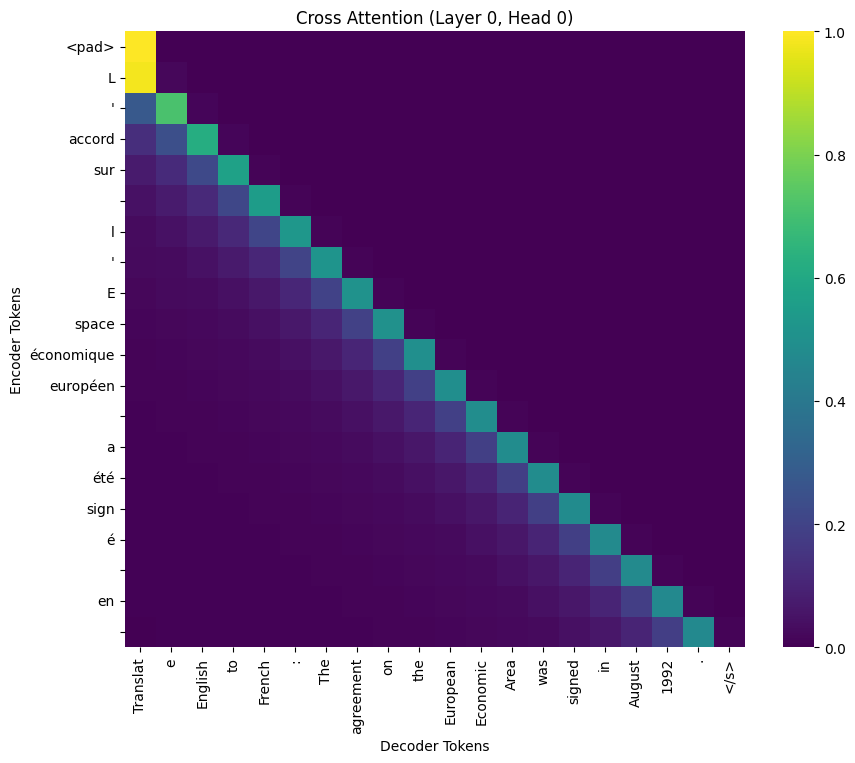

In [8]:
# @title Visualize Attention Weights
text = "Translate English to French: The agreement on the European Economic Area was signed in August 1992." # @param {type:"string"}
layer_to_visualize = -1 # @param {type:"integer"}
head_to_visualize = -1 # @param {type:"integer"}
attention_type = "cross" # @param ["cross", "self"]

def visualize_attention(attention_weights, tokens, output_tokens, layer_num, head_num, attention_type):
  attention = attention_weights[layer_num][head_num].detach().cpu().numpy()

  plt.figure(figsize=(10, 8))
  if attention_type == "cross":
    sns.heatmap(attention, xticklabels=tokens, yticklabels=output_tokens, annot=False, cmap='viridis')
  else:
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=False, cmap='viridis')

  plt.title(f"{attention_type.title()} Attention (Layer {layer_num + 1}, Head {head_num + 1})")
  plt.xlabel("Decoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.ylabel("Encoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.show()

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model.eval()

self_attentions, cross_attentions, output_sequences = get_attention_weights(text, model, tokenizer)

input_tokens = [tokenizer.decode(token_id) for token_id in tokenizer(text, return_tensors="pt")['input_ids'][0]]
output_tokens = [tokenizer.decode(token_id) for token_id in output_sequences[0]]

if attention_type == "cross":
  visualize_attention(cross_attentions[layer_to_visualize], input_tokens, output_tokens, layer_to_visualize, head_to_visualize, "cross")
else:
  visualize_attention(self_attentions[layer_to_visualize], input_tokens, input_tokens, layer_to_visualize, head_to_visualize, "self")


To gain a deeper understanding of the T5 model's attention mechanisms, you should modify various parameters and observe the resulting changes in attention patterns. This analysis will reveal how the model allocates attention at different stages of processing and how each head within the layers may capture different types of information.

As you perform the analysis, consider the following questions:

<font color="green"><b>

8. How do attention patterns differ between the first and last layers of the model? What does this suggest about the role of initial versus deeper layers in processing the input?
9. What variations do you observe in the attention patterns of different heads within the same layer? Can you hypothesize what different types of information each head might be capturing?
10. How does the complexity or length of the input text influence the attention patterns? Do certain types of sentences result in more or less attention spread across the input tokens?

</b></font>

Document your observations and hypotheses regarding the different attention patterns you observe. Answer the questions provided, supporting your answers with specific examples from your visualizations. This exercise will help you understand the nuanced ways in which the T5 model processes and translates input sequences.







سوال ۸:
لایه های ابتدایی یک دید وسیع تر دارند و درک کلی از ورودی پیدا می کنندلایه های آخر معمولا توجه عمیق تر دارند

سوال ۹: هد ها یمختلف یک لایه می تواند میزان توجه های متفاوتی داشته باشدبعضی از هد ها می تواند به توکن های سری توجه کنند بعضی به توکن های دیگر.

سوال ۱۰: طول ورودی می تواند می تواند بر توجه تاثیر بگذارد همان طور که مشاهده می شود یک متن طولانی با عث می شود توجه کاسته شود و مدل نیازمند این می شود که اطلاعات مخلفی را تجمیع کند.